## Super resolution

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

from pathlib import Path

In [2]:
# # See how many devices are around
# torch.cuda.device_count()
# ------
# Set it to a particular device
torch.cuda.set_device(1)
# ------
# Check which device you are on
torch.cuda.current_device()

1

In [3]:
path = Path('/home/dl/data/vrep/')
path_noisy = path/'cam_1_tex' #h
path_clean = path/'cam_1_can' #l

In [4]:
il = ImageItemList.from_folder(path_noisy)

In [5]:
bs,size=2,512
arch = models.resnet34
src = ImageImageList.from_folder(path_noisy).random_split_by_pct(0.1, seed=42)

In [6]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_clean/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [7]:
data = get_data(bs,size)

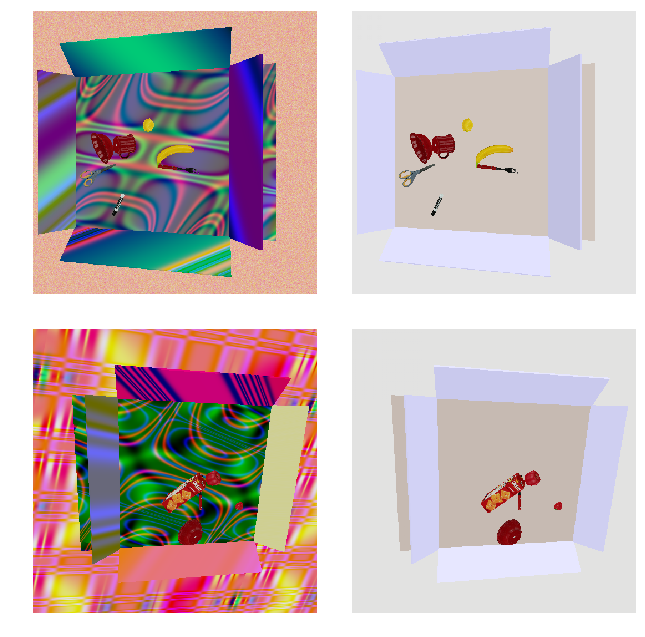

In [8]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [9]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [10]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [11]:
gram_matrix(t)

tensor([[[0.2371, 0.2326, 0.2399],
         [0.2326, 0.2289, 0.2365],
         [0.2399, 0.2365, 0.2466]],

        [[0.2371, 0.2326, 0.2399],
         [0.2326, 0.2289, 0.2365],
         [0.2399, 0.2365, 0.2466]]])

In [12]:
base_loss = F.mse_loss

In [13]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [14]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [15]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [16]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [17]:
wd = 1e-3

learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = (1e-3+1e-4)/2

In [ ]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=10, imgsize=5)

In [ ]:
do_fit('1a', slice(lr*10))

In [ ]:
do_fit('1b', slice(1e-4))

In [ ]:
do_fit('1c', slice(1e-5))

In [ ]:
data = get_data(bs//2,size*2)
learn.data = data
learn.freeze()

In [ ]:
do_fit('2a')

## Test

In [18]:
learn.load('3a')

RuntimeError: CUDA error: out of memory

In [ ]:
data_test = (ImageImageList.from_folder(path_noisy).random_split_by_pct(0.1, seed=42)
          .label_from_func(lambda x: path_clean/x.name)
          .transform(get_transforms(), size=(256,256), tfm_y=True)
          .databunch(bs=2).normalize(imagenet_stats, do_y=True))

In [ ]:
learn.data = data_test

In [ ]:
fn = data_test.valid_ds.x.items[1]; fn

In [ ]:
import glob

In [ ]:
file = glob.glob('test/*.jpg')[0]

In [ ]:
img = open_image(file); img.shape

In [ ]:
_,img_hr,b = learn.predict(img)

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest')

In [ ]:
Image(img_hr).show(figsize=(18,15))